In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
items = pd.read_json('../data/items_20251013_174625.jsonl', lines=True)
items['time'] = pd.to_datetime(items['time'], unit='s')

users = pd.read_json('../data/users_20251013_174625.jsonl', lines=True)
users['created'] = pd.to_datetime(users['created'], unit='s')
# Display the first few rows
items.head()

,id,type,by,time,text,dead,deleted,parent,poll,kids,url,score,title,parts,descendants
0,45568880,comment,moogly,2025-10-13 14:45:58,Probably the 2nd most baffling thing in Zig fo...,NaN,NaN,45565876.0,NaN,[],None,NaN,None,[],NaN
1,45568879,comment,nchmy,2025-10-13 14:45:51,what im most impressed by when I read the comm...,NaN,NaN,45566421.0,NaN,[],None,NaN,None,[],NaN
2,45568878,comment,stavros,2025-10-13 14:45:48,&gt; You start out the article with hate for g...,NaN,NaN,45568791.0,NaN,[],None,NaN,None,[],NaN
3,45568877,comment,xrd,2025-10-13 14:45:43,Am I wrong if this feels like high frequency t...,NaN,NaN,45566992.0,NaN,[],None,NaN,None,[],NaN
4,45568876,comment,cindyllm,2025-10-13 14:45:41,[dead],1.0,NaN,45568741.0,NaN,[],None,NaN,None,[],NaN


In [3]:
users.head()

,id,created,karma,about,submitted
0,moogly,2013-04-28 10:49:43,2485,None,"[45568880, 45568848, 45565311, 45562957, 45521..."
1,nchmy,2023-03-10 04:08:40,902,None,"[45568879, 45568851, 45568831, 45568810, 45568..."
2,stavros,2010-04-24 14:28:05,73010,"I&#x27;m Stavros. If you need to contact me, m...","[45568878, 45568546, 45568415, 45568353, 45568..."
3,xrd,2008-03-25 15:34:50,8106,chris@extrastatic.com<p>https:&#x2F;&#x2F;webi...,"[45568877, 45558255, 45553232, 45553219, 45530..."
4,cindyllm,2025-03-06 16:45:07,-20,She started ALL OF IT<p>https:&#x2F;&#x2F;www....,"[45568876, 45565953, 45565539, 45564819, 45564..."


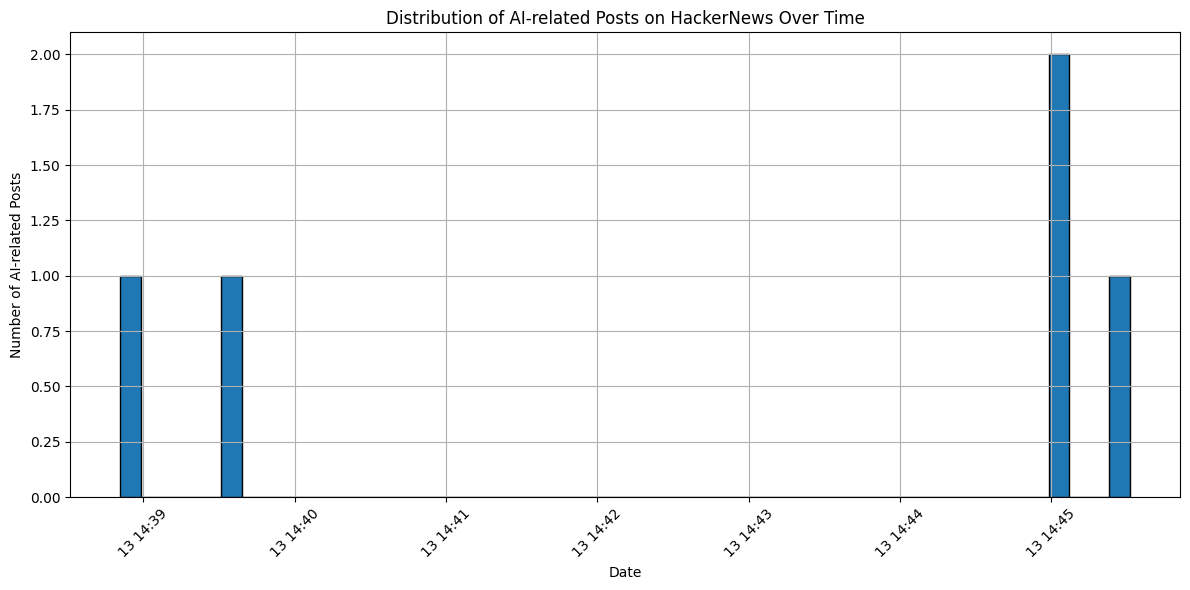

In [4]:
# 1. In general, how many posts are related to AI over time on HackerNews? 
ai_posts = items[items['title'].str.contains('AI', case=False, na=False)]

# Create histogram
plt.figure(figsize=(12, 6))
ai_posts['time'].hist(bins=50, edgecolor='black')
plt.xlabel('Date')
plt.ylabel('Number of AI-related Posts')
plt.title('Distribution of AI-related Posts on HackerNews Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

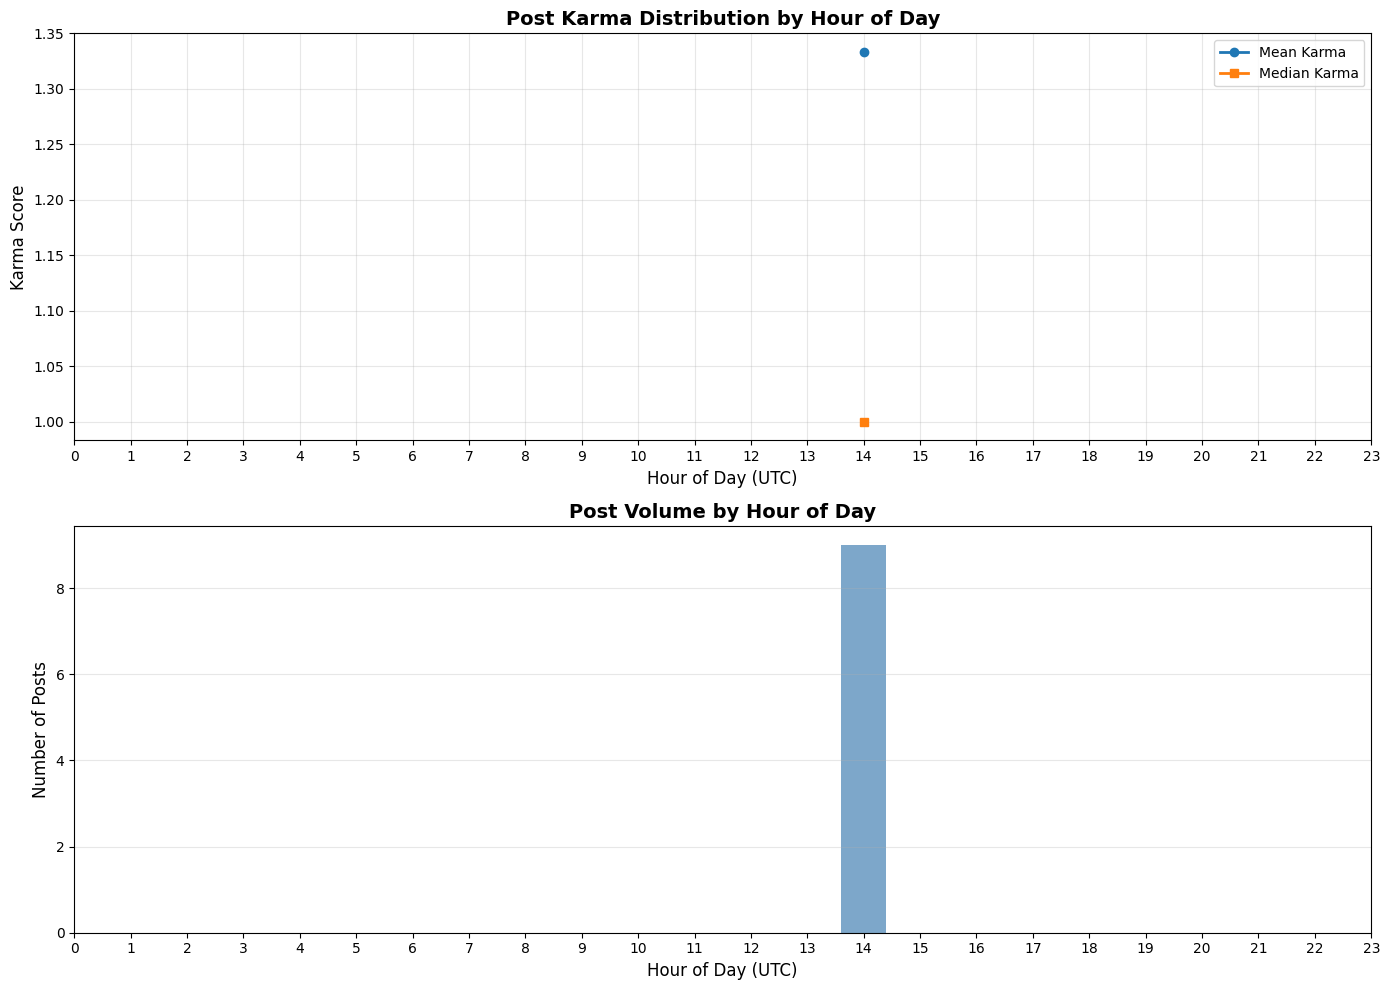

Karma Statistics by Hour of Day:
      mean  median  count
hour                     
14    1.33     1.0      9

Best hours for karma (by mean): [14]
Worst hours for karma (by mean): [14]


In [5]:
# What is the right time and day to post?

# Extract hour from timestamp
items['hour'] = items['time'].dt.hour

# Calculate average karma by hour
karma_by_hour = items.groupby('hour')['score'].agg(['mean', 'median', 'count'])

# Create visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Average and Median Karma by Hour
axes[0].plot(karma_by_hour.index, karma_by_hour['mean'], marker='o', label='Mean Karma', linewidth=2)
axes[0].plot(karma_by_hour.index, karma_by_hour['median'], marker='s', label='Median Karma', linewidth=2)
axes[0].set_xlabel('Hour of Day (UTC)', fontsize=12)
axes[0].set_ylabel('Karma Score', fontsize=12)
axes[0].set_title('Post Karma Distribution by Hour of Day', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(24))

# Plot 2: Number of Posts by Hour
axes[1].bar(karma_by_hour.index, karma_by_hour['count'], color='steelblue', alpha=0.7)
axes[1].set_xlabel('Hour of Day (UTC)', fontsize=12)
axes[1].set_ylabel('Number of Posts', fontsize=12)
axes[1].set_title('Post Volume by Hour of Day', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticks(range(24))

plt.tight_layout()
plt.show()

# Display summary statistics
print("Karma Statistics by Hour of Day:")
print(karma_by_hour.round(2))
print(f"\nBest hours for karma (by mean): {karma_by_hour['mean'].nlargest(5).index.tolist()}")
print(f"Worst hours for karma (by mean): {karma_by_hour['mean'].nsmallest(5).index.tolist()}")

In [ ]:
# Is there a best way to write a title for a post?
items[items['type'].isin(['story', 'poll', 'job'])][['title', 'score']].sort_values(by='score', ascending=False).head(10)

# Outcome with full data

,title,score
59,Landline and mobile networks down across UK,3.0
16,OpenAI partners with Broadcom to design its ow...,2.0
6,The War Against Indiscipline,1.0
41,Route 53 DNS: Amazon's premier AWS database,1.0
14,Show HN: AI Code Scanning/SAST,1.0
53,None,1.0
69,None,1.0
70,TrustGraph built enterprise-grade agentic AI w...,1.0
79,Anyone knows the 'biology' of AI coding models...,1.0
